In [ ]:
from pyprojroot import here
import polars as pl
from polars import col as c
from pdal import Writer, Reader
from tqdm.auto import tqdm
from functools import partial
from plotnine import *

theme_set(theme_bw());

In [2]:
las_path = here("data/tree.las")

## LAS/LAZ

LAS is one of the most common formats for point clouds. The compressed version (LAZ) is also widely supported.


The advantages of LAS/LAZ are:
 - explicit support for point clouds with all metadata (this includes geographic coordinates)
 - stores coordinates as uint16 transformed by a scale and offset, this allows to use a wide range of CRS. Compared to simply storing as a `float32` it takes half the space and more importantly guarantees the level of precision across the entire range of coordinates.
 - LAZ compression is efficient and widely supported
 - with COPC enables a spatial index
The disadvantages of LAS/LAZ are:
- it stores a lot of additional data (like scan angle) that in TLS context is not relevant
- non-standard way to add attribues like normals that can be useful for TLS processing

Then the LAZ is optimized by storing the coordinates with a resolution of 1cm instead of the default of 0.25 cm from RiSCAN PRO. This results in a loss of data, but often point clouds are anyway downsampled.

In [69]:
formats = [
    {
        "name": "LAS simple",
        "file_path": las_path,
        "writer": partial(Writer.las, forward="all"), # forward all needed to overwrite PDAL defaults
    },
    {
        "name": "LAZ simple",
        "file_path": las_path.with_suffix(".laz"),
        "writer": partial(Writer.las, forward="all"),
    },
    {
        "name": "LAZ optimized",
        "file_path": las_path.with_name("tree_opt.laz"),
        "writer": partial(
            Writer.las, forward="all", scale_x=0.01, scale_y=0.01, scale_z=0.01
        ),
    },
]


## PLY

PLY is another common format for point clouds. The 

In [70]:
formats += [
    {
        "name": "PLY simple",
        "file_path": las_path.with_suffix(".ply"),
        "writer": Writer.ply,
    },
    {
        "name": "PLY binary",
        "file_path": las_path.with_name("tree_binary.ply"),
        "writer": partial(Writer.ply, storage_mode="little endian"),
    },
    {
        "name": "PLY optimized",
        "file_path": las_path.with_name("tree_opt.ply"),
        "writer": partial(
            Writer.ply, dims="X=float,Y=float,Z=float", storage_mode="little endian"
        ),
    },
]


In [71]:
formats += [
    {
        "name": "PCD simple",
        "file_path": las_path.with_suffix(".pcd"),
        "writer": Writer.pcd,
    },
    {
        "name": "PCD optimized",
        "file_path": las_path.with_name("tree_opt.pcd"),
        "writer": partial(Writer.pcd, compression="binary"),
    },
]

In [72]:
formats += [
    {
        "name": "Text simple",
        "file_path": las_path.with_suffix(".txt"),
        "writer": Writer.text,
    }
]

# Run test

In [73]:
base_pipe = Reader.las(las_path).pipeline()

In [74]:
def test_format(file_path, writer) -> int:
    pipe = base_pipe | writer(filename=file_path)
    pipe.execute()
    return file_path.stat().st_size

In [75]:
test_format(formats[0]["file_path"], formats[0]["writer"])

21388101

In [76]:
def test_formats(formats):
    results = []
    for fmt in tqdm(formats):
        size = test_format(fmt["file_path"], fmt["writer"])
        results.append({"format": fmt["name"], "size": size})
    return pl.DataFrame(results)

In [77]:
df = test_formats(formats)

  0%|          | 0/9 [00:00<?, ?it/s]

PDAL PCD format is stupid is stores everything as a double by default and it doesn't allow to filter columns

# Results

In [78]:
df = df.with_columns(rel_size=c.size / c.size.first(), size_mb=c.size / 1024**2)
df

format,size,rel_size,size_mb
str,i64,f64,f64
"""LAS simple""",21388101,1.0,20.397283
"""LAZ simple""",8108643,0.379119,7.733005
"""LAZ optimized""",6935301,0.32426,6.614018
"""PLY simple""",50357814,2.354478,48.024954
"""PLY binary""",33861820,1.583208,32.293148
"""PLY optimized""",7128824,0.333308,6.798576
"""PCD simple""",81959430,3.832011,78.162603
"""PCD optimized""",92673186,4.332932,88.380037
"""Text simple""",93840346,4.387502,89.493128


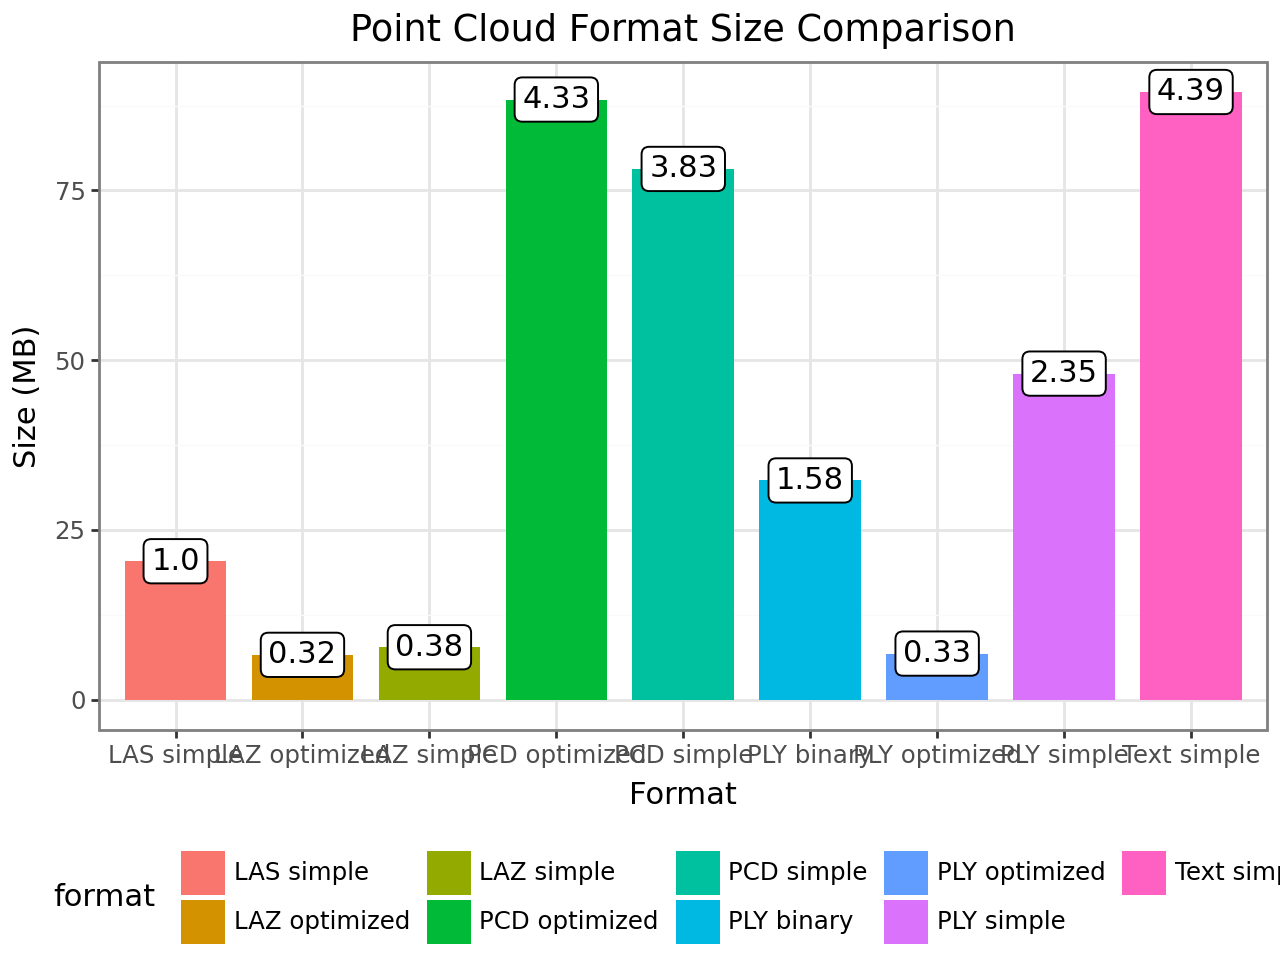

In [82]:
(
    ggplot(df)
    + aes(x="format", y="size_mb")
    + geom_col(aes(fill="format"), width=0.8)
    + geom_label(aes(label="rel_size.round(2)"))
    + labs(title="Point Cloud Format Size Comparison", x="Format", y="Size (MB)")
    + theme(legend_position="bottom")
)

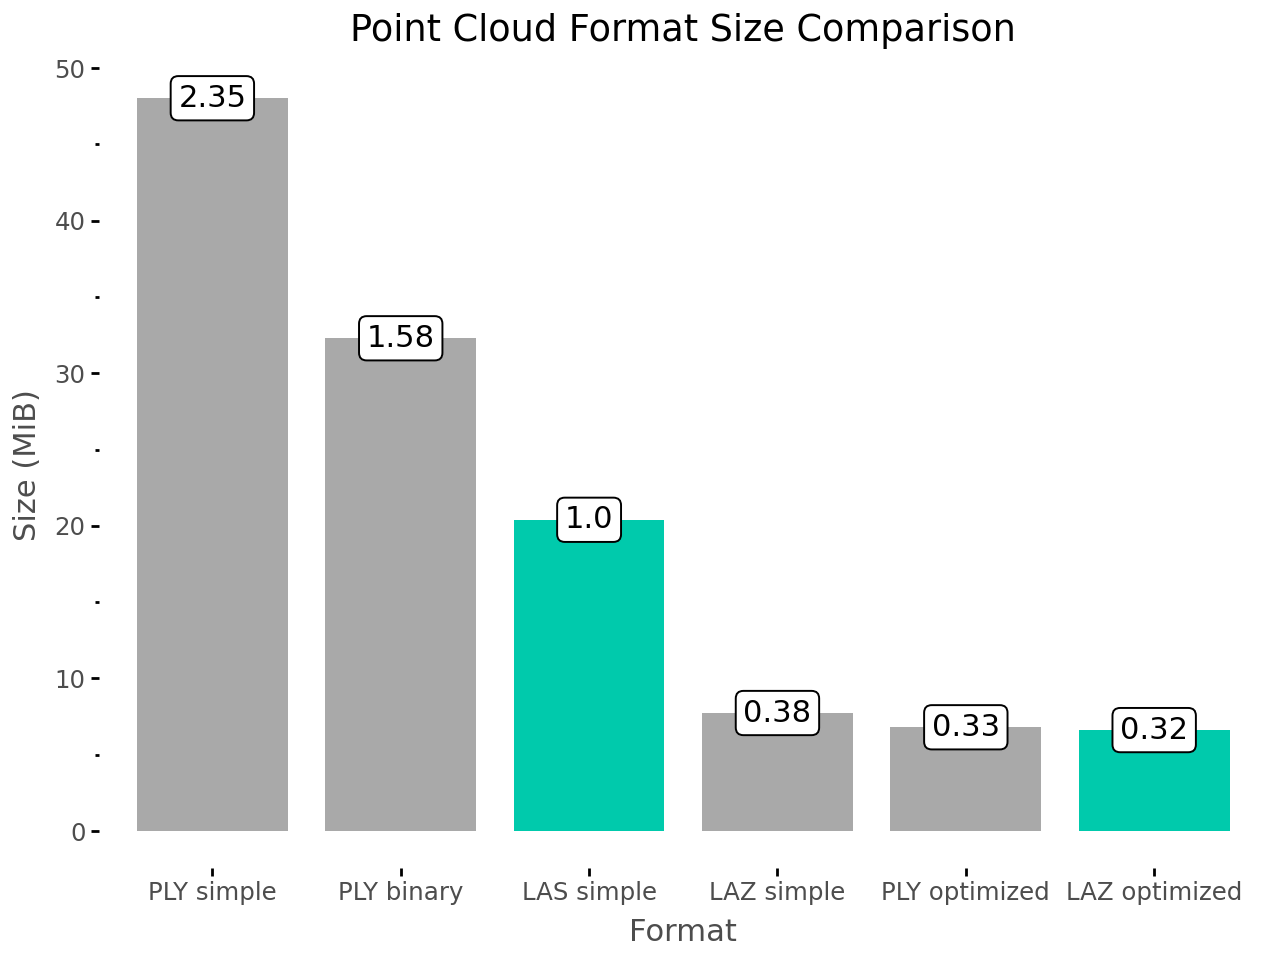

In [81]:
(
    df.filter(~c.format.str.starts_with("PCD"), ~c.format.str.starts_with("Text"))
    .sort("size_mb", descending=True)
    .with_columns(c.format.cast(pl.Categorical))
    >> ggplot()
    + aes(x="format", y="size_mb")
    + geom_col(aes(fill="format"), width=0.8)
    + scale_fill_manual(
        values={
            "LAS simple": "#00caac",
            "LAZ optimized": "#00caac",
            "LAZ simple": "darkgrey",
            "PLY simple": "darkgrey",
            "PLY binary": "darkgrey",
            "PLY optimized": "darkgrey",
        },
    )
    + geom_label(aes(label="rel_size.round(2)"))
    + labs(title="Point Cloud Format Size Comparison", x="Format", y="Size (MiB)")
    + theme_minimal()
    + theme(
        legend_position="none",
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks=element_line(),
        axis_title=element_text(color="#4D4D4D"),
    )
)